# Implemented: Conway's Game Of Life 

Progress:   5% | Elapsed:   0.7s | Remaining:  13.6s
Progress:  10% | Elapsed:   0.9s | Remaining:   8.1s
Progress:  15% | Elapsed:   1.0s | Remaining:   5.5s
Progress:  20% | Elapsed:   1.0s | Remaining:   4.2s
Progress:  25% | Elapsed:   1.1s | Remaining:   3.3s
Progress:  30% | Elapsed:   1.2s | Remaining:   2.8s
Progress:  35% | Elapsed:   1.3s | Remaining:   2.4s
Progress:  40% | Elapsed:   1.3s | Remaining:   2.0s
Progress:  45% | Elapsed:   1.4s | Remaining:   1.7s
Progress:  50% | Elapsed:   1.5s | Remaining:   1.5s
Progress:  55% | Elapsed:   1.6s | Remaining:   1.3s
Progress:  60% | Elapsed:   1.6s | Remaining:   1.1s
Progress:  65% | Elapsed:   1.7s | Remaining:   0.9s
Progress:  70% | Elapsed:   1.8s | Remaining:   0.8s
Progress:  75% | Elapsed:   1.8s | Remaining:   0.6s
Progress:  80% | Elapsed:   1.9s | Remaining:   0.5s
Progress:  85% | Elapsed:   2.0s | Remaining:   0.3s
Progress:  90% | Elapsed:   2.0s | Remaining:   0.2s
Progress:  95% | Elapsed:   2.1s | Remaining: 

[ Info: Saved animation to /Users/lb788/Documents/Julia_Review_CfRR/CfRR_Courses/individual_modules/introduction_to_julia/life_naive.gif


Saved naive animation to life_naive.gif


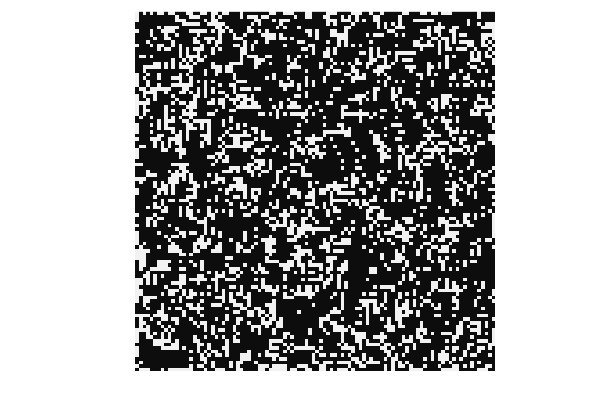

In [1]:
using Random
using Plots
using Printf
using IJulia

# Naïve neighbor‐counting and state update functions (as before)…
function count_neighbors_naive(grid::Matrix{Bool}, i::Int, j::Int)::Int
    cnt = 0
    for di in -1:1, dj in -1:1
        if di != 0 || dj != 0
            i2, j2 = i + di, j + dj
            if 1 ≤ i2 ≤ size(grid,1) && 1 ≤ j2 ≤ size(grid,2)
                cnt += grid[i2, j2]
            end
        end
    end
    return cnt
end

function next_state_naive(grid::Matrix{Bool})::Matrix{Bool}
    N1, N2 = size(grid)
    newgrid = falses(N1, N2)
    for i in 1:N1, j in 1:N2
        cnt = count_neighbors_naive(grid, i, j)
        newgrid[i,j] = (grid[i,j] && (cnt == 2 || cnt == 3)) ||
                       (!grid[i,j] && cnt == 3)
    end
    return newgrid
end

function run_naive_simulation(grid::Matrix{Bool}, steps::Int; print_interval_percent::Int=10)
    # how many iterations per print
    step_interval = max(1, floor(Int, steps * print_interval_percent / 100))

    t_start = time()   # record start time in seconds

    anim = @animate for step in 1:steps
        grid = next_state_naive(grid)

        if step % step_interval == 0
            pct     = step / steps * 100
            elapsed = time() - t_start
            avg     = elapsed / step
            remain  = avg * (steps - step)
            @printf("Progress: %3.0f%% | Elapsed: %5.1fs | Remaining: %5.1fs\n",
                    pct, elapsed, remain)
        end

        heatmap(
            grid;
            color = :grays,
            axis = false,
            legend = false,
            framestyle = :none,
            aspect_ratio = 1
        )
    end

    gif(anim, "life_naive.gif"; fps = 10)
    println("Saved naive animation to life_naive.gif")

    # now read it in and display only after it's fully written
    data = read("life_naive.gif")
    display("image/gif", data)
end

# Example usage:
const N = 100
grid = Matrix{Bool}(rand(Bool, N, N))
run_naive_simulation(grid, 100; print_interval_percent = 5)
